# Identifying Asteroid Streaks using Convolutional Neural Networks

Asteroids are hypothetically easy to detect. As Solar System objects, they move over time against fixed background sources like stars and galaxies, which in turn do not move at rates that are noticeable over the course of a night. So, in order to find an asteroid, one simply has to image the same field over a long period of time and asteroids will produce linear streaks in the image. 

However, recognizing asteroid streaks is a problem in itself. Common astronomical source detection codes (like [Source Extractor](http://www.astromatic.net/software/sextractor)) are typically tuned to finding point sources (stars) or small extended objects like galaxies. Source Extractor will most likely be able to pick up streaks, but it won't be able to recognize them with high confidence. 

Enter: Convolutional Neural Networks. CNN are often used in image-based classification problems. My question was: *How easy it is to setup a CNN that is able to distinguish between stars and streaks?*

Here we go.

# Generate fake image data

In order to setup a CNN, we need training and test data. I was somewhat reluctant to search through thousands of astronomical images to find asteroid streaks manually, so I generate some fake image data that should be reasonably similar to real image data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, ZScaleInterval, LinearStretch, ImageNormalize)

# set random seed
np.random.seed(42)

First, I create a empty 10k by 10k image and implant 50000 point sources (single pixels) at random positions and with random flux (brightness).

In [2]:
# create empty frame
extent = (10000, 10000)
data = np.zeros(extent)

# create sources (stars): positions and flux
n_sources = 50000
sources = np.random.rand(n_sources, 3)
sources[:,0] = (sources[:,0]*extent[0]).astype(int) # x
sources[:,1] = (sources[:,1]*extent[1]).astype(int) # y

# implant sources
for source in sources:
    data[int(source[0]), int(source[1])] = source[2]

Next, I am adding 50000 asteroid streaks (that's a huge number and highly exaggerated in order to have a balanced training set of stars and asteroids). Each streak consists of a start position (x and y), an angle indicating the direction of movement of the streak from the start position, a length of the streak in pixels, and a flux. The flux is scaled down in order to create a more realistic impression: during a long exposure, the flux of stars falls on the same number of pixels, whereas the flux of a moving object is spread over a larger number of pixels, making the streak generally fainter. The streaks are implanted into the image.

In [3]:
# create streaks: start positions, direction, length, flux
n_streaks = 50000

streaks = np.random.rand(n_streaks, 5)
streaks[:,0] = (streaks[:,0]*extent[0]).astype(int) # x
streaks[:,1] = (streaks[:,1]*extent[1]).astype(int) # y
streaks[:,2] = streaks[:,2]*2*np.pi  # direction in radians
streaks[:,3] = (streaks[:,3]*10).astype(int)+2 # length in px
streaks[:,4] = streaks[:,4]/np.log(streaks[:,3]+1) # reduce streak brightness


# implant streaks
for streak in streaks:
    x, y = streak[0], streak[1]
    data[int(np.floor(x)), int(np.floor(y))] = streak[4]
    for l in range(int(streak[3])):
        x += np.cos(streak[2])
        y += np.sin(streak[2])
        try:
            data[int(np.floor(x)), int(np.floor(y))] = streak[4] 
        except IndexError:
            pass

Let's plot a small cutout of this image.

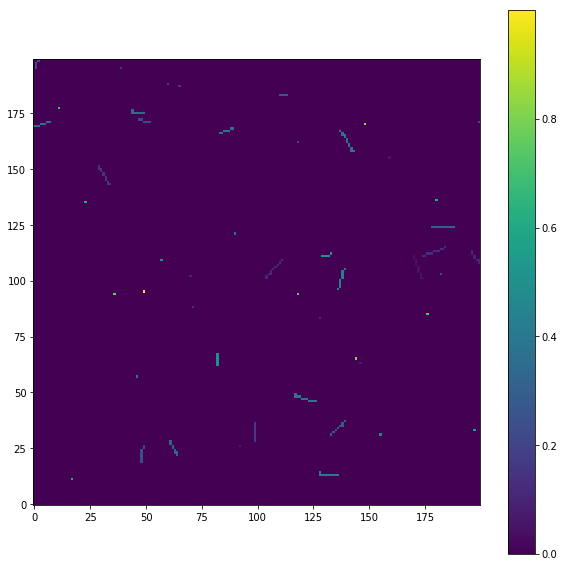

In [4]:
norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=LinearStretch())

f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data[:200, :200], norm=norm, origin='lower')
f.colorbar(im)

Stars and streaks are clearly distinguishable to the human eye. However, this image looks too perfect. In order to make the image more realistic, we convolve this image with a kernel, simulating a telescope point spread function

In [5]:
# create kernel
from scipy.stats import norm

y, x = np.mgrid[-4:5, -4:5]
kernel = norm.pdf(x)*norm.pdf(y)

We choose a 5 by 5 pixel point spread function...

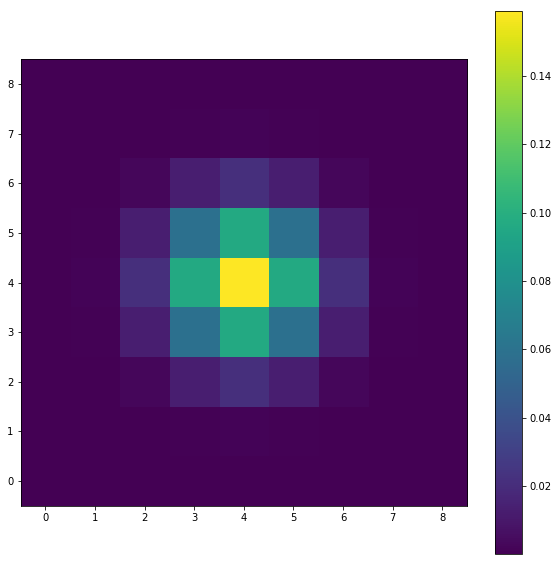

In [6]:
norm = ImageNormalize(kernel, interval=MinMaxInterval(), stretch=LinearStretch())

f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(kernel, norm=norm, origin='lower')
f.colorbar(im)

... and convolve it with the original image...

In [7]:
from scipy.signal import convolve2d

data = convolve2d(data, kernel, boundary='wrap', mode='same')

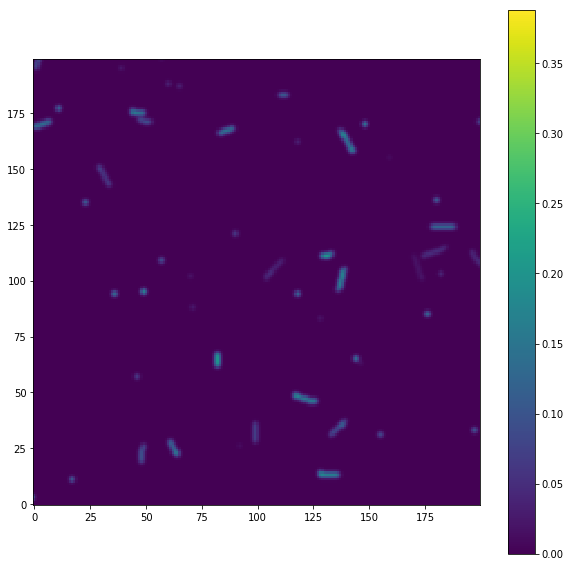

In [8]:
norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=LinearStretch())

f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data[:200, :200], norm=norm, origin='lower')
f.colorbar(im)

This looks more realistic, but one important component is still missing: noise. Background noise is present in all astronomical images, so let's implant some uniform Gaussian noise.

In [9]:
background = np.abs(np.random.normal(size=extent, scale=0.005))
data = data + background

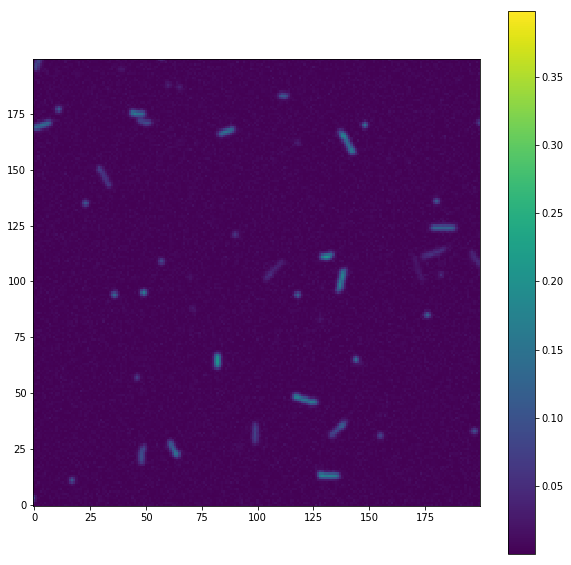

In [10]:
norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=LinearStretch())

f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data[:200, :200], norm=norm, origin='lower')
f.colorbar(im)

This looks pretty similar to a real astronomical image. Let's work with this data and extract a thumbnail image for each star and each streak.

# Extract thumbnail images

In [11]:
source_thumbs = []
for source in sources:
    try:
        x, y = source[0], source[1]
        thumb_data = data[int(x)-7:int(x)+8, 
                          int(y)-7:int(y)+8]
        if thumb_data.shape == (15,15):
            source_thumbs.append(thumb_data)
    except ValueError:
        pass
    
source_thumbs = np.array(source_thumbs)

In [12]:
print(len(source_thumbs), 'stars extracted')

49852 stars extracted


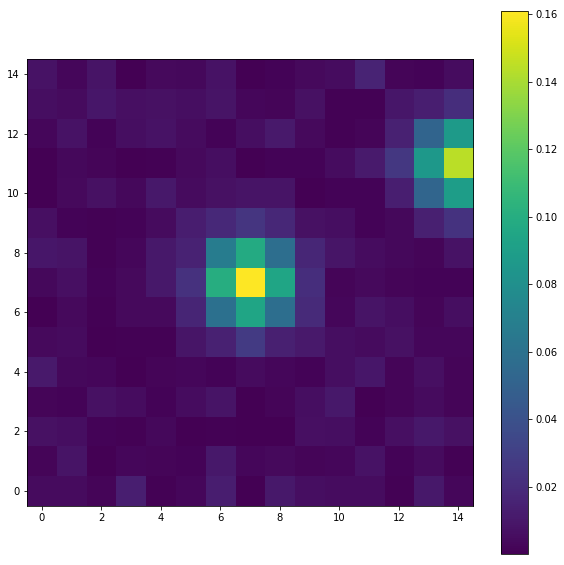

In [13]:
thumb=source_thumbs[3]

norm = ImageNormalize(thumb, interval=MinMaxInterval(), stretch=LinearStretch())

f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(thumb, norm=norm, origin='lower')
f.colorbar(im)

In [14]:
streak_thumbs = []
for streak in streaks:
    x, y = streak[0], streak[1]
    x += streak[3]/2 * np.cos(streak[2])
    y += streak[3]/2 * np.sin(streak[2])
    try:
        thumb_data = data[int(x)-7:int(x)+8, 
                          int(y)-7:int(y)+8]
        if thumb_data.shape == (15,15):
            streak_thumbs.append(thumb_data)
    except ValueError:
        pass
    
#streak_thumbs    
streak_thumbs = np.array(streak_thumbs)

In [15]:
print(len(streak_thumbs), 'streaks extracted')

49843 streaks extracted


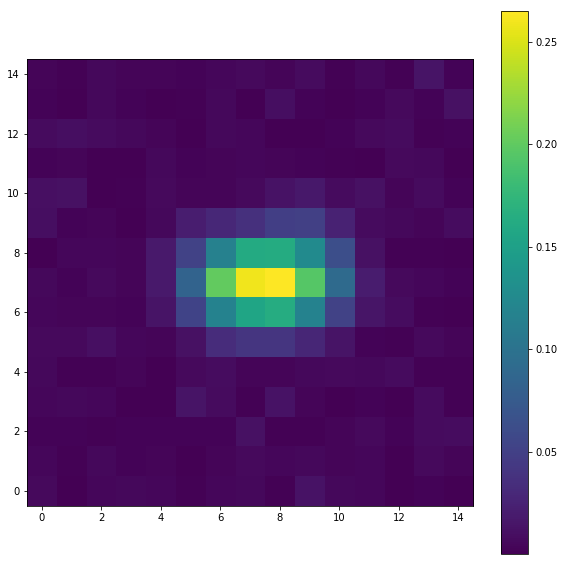

In [16]:
thumb=streak_thumbs[2]

norm = ImageNormalize(thumb, interval=MinMaxInterval(), stretch=LinearStretch())

f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(thumb, norm=norm, origin='lower')
f.colorbar(im)

## Preparing the Data Set

I combine the sets of stars and streaks and split the combined data set into a training and a test data set.

In [17]:
from sklearn.model_selection import train_test_split

target = np.append(np.zeros(len(source_thumbs)), np.ones(len(streak_thumbs)))
thumbs = np.append(source_thumbs, streak_thumbs, axis=0)

x_train, x_test, y_train, y_test = train_test_split(thumbs, target, test_size=0.2, random_state=42)

# Modeling

I setup a simple CNN with two convolutional layers and two dense layers, all of which are using ReLU activation function. 40% random dropout between the dense layer are used for generalization. Finally, a binary layer with softmax activation is used as an output layer.

The model setup is based on [this](https://github.com/mommermi/Advanced-Deep-Learning-with-Keras/blob/master/chapter1-keras-quick-tour/cnn-model-1.3.2.py) model as presented in the book "Advanced Deep Learning with Keras" by Rowel Atienza.

The entire model is setup as a sequential model using keras and trained on the training data set.

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical

/home/mommermi/software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=5, activation='relu', strides=1, input_shape=(15, 15, 1), padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', strides=1))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.summary()

model.fit(x_train.reshape((-1, 15, 15, 1)), to_categorical(y_train), epochs=5, batch_size=64)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1081800   
_________________________________________________________________
dropout_2 (Dropout)  

In [20]:
loss, acc = model.evaluate(x_test.reshape((-1, 15, 15, 1)), to_categorical(y_test), batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

19939/19939 [==============================] - 6s 298us/step

Test accuracy: 97.4%


This very simple model results in a classification accuracy of ~98%, which is pretty amazing. This accuracy can probably be increased by fine-tuning the model.

The answer to my question in the introduction is thus: it's pretty easy to setup a CNN to recognize asteroid streaks!

## Discussion

This notebook uses a number of simplifications that should be considered here:
* The data on which this toy project is based are synthetic; real data will be much harder to deal with as the night sky not only consists of stars and asteroids, but also of elongated galaxies, satellites, and airplane trails - all of which can be confused with asteroid streaks.
* The model is trained on a relatively large and highly balanced data set, which would be hard to gather from real data, as most asteroids streaks for the training data set will have to be extracted manually.
* Image artifacts like hot or dead pixels, cosmics, or bad columns are not considered here.

Nevertheless, this toy project shows that CNNs should be able to recognize asteroid streaks with high confidence.